# Dot calling

Welcome to the dot calling notebook!

Dot calling finds significantly enriched interactions in the Hi-C map. 
The traditional algorithm for that is HICCUPS (proposed in [Rao et al. 2014](https://doi.org/10.1016/j.cell.2014.11.021). However, the original HICCUPS is written in Java, making it hard to modify the parameters and specific steps.

We implement dot caller in Python and make it easy to control the parameter and processing steps for flexible search of optimal parameters for new Hi-C or Micro-C datasets.

In [1]:
# Setup the environment first: TODO: do we need it with the api update? 

# read: https://github.com/mirnylab/cooler/issues/138 for more details:

# !export MKL_NUM_THREADS=1 - # not working in a notebook ((
# instead do this, after making sure mkl is installed
import mkl
mkl.set_num_threads(1)

from threadpoolctl import threadpool_info
threadpool_info()

[{'filepath': '/home/agalicina/anaconda3/envs/python37/lib/libmkl_rt.so',
  'prefix': 'libmkl_rt',
  'user_api': 'blas',
  'internal_api': 'mkl',
  'version': '2020.0.2',
  'num_threads': 1,
  'threading_layer': 'intel'},
 {'filepath': '/home/agalicina/anaconda3/envs/python37/lib/libiomp5.so',
  'prefix': 'libiomp',
  'user_api': 'openmp',
  'internal_api': 'openmp',
  'version': None,
  'num_threads': 1}]

In [2]:
# If you are a developer, you may want to reload the packages on a fly. 
# Jupyter has a magic for this particular purpose:

%load_ext autoreload
%autoreload 2

In [ ]:
# Visualization imports: 
import matplotlib.pyplot as plt
# TODO: do we need the datashader for basic demonstration? 
import datashader as ds
from datashader.mpl_ext import dsshow, alpha_colormap

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from matplotlib.colors import LogNorm

# TODO: remove below altogether?
# %matplotlib inline
# %config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

# Data processing/manupulation imports: 
import os.path as op
from scipy.stats import poisson
import pandas as pd
import numpy as np

# Hi-C utilities imports: 
import cooler
import bioframe
import cooltools
from cooltools.api import dots

/home/agalicina/anaconda3/envs/python37/lib/python3.7/site-packages/dask/dataframe/utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Download data

In [ ]:
# Download the test data from osf:

cool_file = cooltools.download_data("HFF_MicroC", cache=True, data_dir='./')
print(cool_file)

## CLI for dot calling

In [ ]:
# calculate expected for the regions of interest:
# this is a 10kb cooler file
# and we should also have expected calculated for 10kb:
!cooltools compute-expected \
    --nproc 2 \
    --output test.10kb.cis.exp.tsv \
    --regions hg38_arms.bed \
    --contact-type cis \
    --balance \
    --weight-name weight \
    --ignore-diags 2 \
    ./test.mcool::/resolutions/10000

In [17]:
!cooltools call-dots \
    -p 4 \
    --max-loci-separation 1000000 \
    --tile-size 1000000 \
    --dots-clustering-radius 21000 \
    --fdr 0.1 \
    --verbose \
    -o xxx.bedpe \
    --regions hg38_arms.bed \
    ./test.mcool::/resolutions/10000 \
    test.10kb.cis.exp.tsv

## Load data

For dot calling, we need input cool file with Hi-C data, regions for calculation of expected (chromosomes or chromosome arms).

In [7]:
# Open cool file with Micro-C data:
clr = cooler.Cooler('./test.mcool::/resolutions/10000')
# Set up selected data resolution:
resolution = clr.binsize

In [8]:
# Use bioframe to fetch the genomic features from the UCSC.
hg38_chromsizes = bioframe.fetch_chromsizes('hg38')
hg38_cens = bioframe.fetch_centromeres('hg38')
hg38_arms = bioframe.make_chromarms(hg38_chromsizes, hg38_cens)

# Select only chromosomes that are present in the cooler. 
# This step is typically not required! we call it only because the test data are reduced. 
hg38_arms = hg38_arms.set_index("chrom").loc[clr.chromnames].reset_index()

## Pre-compute expected

In [12]:
expected = cooltools.expected_cis(clr, view_df=hg38_arms, nproc=2, chunksize=1_000_000)

In [ ]:
expected

## Pameters for dot calling

In the original HICCUP algorithm, there is a number of parameters that can be varied for the better fit to your data.
Here, we describe these parameters and describe how to modify them with cooltools:

In [11]:
# specify parameters for call-dots
expected_name = 'balanced.avg'
nproc = 4
max_loci_separation = 1_000_000
max_nans_tolerated = 4
tile_size = 1_000_000
fdr = 0.1
dots_clustering_radius = 21_000
verbose = True
balancing_weight_name = "weight"
temp_dir = './'
no_delete_temp = True

# Prepare some parameters.
binsize = clr.binsize
loci_separation_bins = int(max_loci_separation / binsize) # how many diagonals to be considered
tile_size_bins = int(tile_size / binsize)

print("we are dealing with the data binned at {}".format(binsize))

# clustering would deal with bases-units for now, so supress this for now
# clustering_radius_bins = int(dots_clustering_radius/binsize)

# pre-defined kernel types that are going to be used in the analysis
ktypes = ['donut', 'vertical', 'horizontal', 'lowleft']

we are dealing with the data binned at 10000


### Kernels used to define local enrichment of a pixel

 - Dots observed on Hi-C heatmaps as *small* and concentrated clusters of locally enriched pixels.
 - Biologically relevant sizes of such clusters and their surroundings are empirically defined at `~50kb` for the diameter of clusters, and `~100kb` for the diameter of the local surrounding
 - Several types of kernels (i.e. local environments) could be used to rule out unwanted enrichment types, e.g. elongated clusters, large corners, etc.
 - One can choose from pre-defined set of kernels from *Rao et al 2014*, or provide custome ones
 - Even for the predefined set of kernels one can control their parameters `w` and `p`, where `2w+1` is the outter dimensions of kernel's footprint and `2p+1` is the inner one, the approximate size of an enriched cluster of pixels
 - function `recommend_kernel_params` would yield recommended `w` and `p` for a given bin size, as in *Rao et al 2014*, otherwise feel free to experiment with those

In [13]:
w,p = dotfinder.recommend_kernel_params(binsize)
print("Kernel parameters w={} p={}".format(w,p))

kernels = {k: dotfinder.get_kernel(w, p, k) for k in ktypes}
# list of tile coordinate ranges
tiles = list(
    dotfinder.heatmap_tiles_generator_diag(
        clr,
        hg38_arms,
        w,
        tile_size_bins,
        loci_separation_bins
    )
)   

Kernel parameters w=5 p=2


In [5]:
def draw_kernel(kernel,
                axis,
                cmap='viridis'):
    # kernel:
    imk = axis.imshow(
                    kernel[::-1,::-1],
                    alpha=0.7,
                    cmap=cmap,
                    interpolation='nearest')
    # clean axis:
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_xticklabels('',visible=False)
    axis.set_yticklabels('',visible=False)
    axis.set_title("{} kernel".format(ktype),fontsize=16)
    # add a checkerboard to highlight pixels:
    checkerboard = np.add.outer(range(kernel.shape[0]),
                                range(kernel.shape[1])) % 2
    # show it:
    axis.imshow(checkerboard,
            cmap='gray',
            interpolation='nearest',
            alpha=0.3)
    #
    return imk

[Text(1, 0, 'Excluded from calculation'),
 Text(1, 0, 'Included in calculations')]

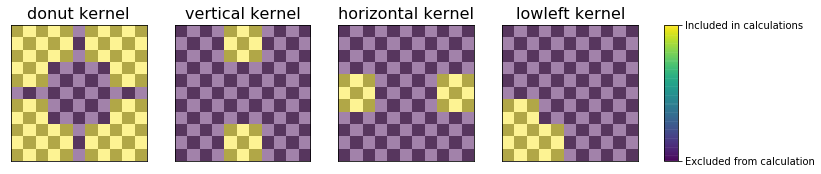

In [14]:
# it is important to demonstrate filters here 
# consider moving plotting code elsewhere or simplify it significantly ...
# split cell above and demonstrate kernels - it's nice:
fig = plt.figure(figsize=(12,2.5))
gs = plt.GridSpec(nrows=1,
            ncols=5,
            figure=fig,
            width_ratios=[1,1,1,1,0.1])

for i,ktype in enumerate(ktypes):
    kernel= kernels[ktype]
    ax = plt.subplot(gs[i])
    imk = draw_kernel(kernel,ax)
    
# colorbar and that's it:
ax = plt.subplot(gs[i+1])
cb = fig.colorbar(imk, cax=ax)
cb.ax.get_yaxis().set_major_locator(ticker.MaxNLocator(1))
cb.ax.set_yticklabels(['Excluded from calculation','Included in calculations'])

## Dot calling

In [ ]:
dots = dots(
    clr,
    expected,
    expected_value_col="balanced.avg",
    view_df=hg38_arms,
    kernels = {}, # mask, kernel, filter ...
    clustering_radius=20_000,  # None or False would switch clustering off
    clr_weight_name="weight",
    fdr=.1,
    max_loci_separation=10_000_000,
    max_nans_tolerated=1,
    num_lambda_chunks=40,  # should get rid of this param eventually
    tile_size=5_000_000, # execution detail - does not affect the result
    nproc=1,
)

In [ ]:
dots

In [ ]:
### Visualization of dots against the Hi-C map

# Technical notes

The code below should be probably removed or substantially modified for the pro-users.

a little remark on the `lowleft` kernel:
 - by the definition of convolution, it implies integrating f(x)*g(-x) ...
 - in other words the kernel is being "flipped" when it is applied to a matrix
 - we should try to make it explicit or hide it away on a better way

### Getting to the calculations of locally-adjusted expected

 - for demonstration and debugging purposes we are going to dump the dataframe with locally adjusted expected right in place (i.e. in memory).
 - This might be also ok for smaller genomes and potentially for small subsets of large genomes.
 - This is not recommended whatsoever for genome-wide dot-calling.

A side note, we've tried to store all of the values in a separate file,
but practice shows that for large genomes even parquet/hdf5 are not fast enough.
Thus using a **2-pass** strategy seems to be the best option indeed.

**2-pass**: calculate locally-adjusted expected for each pixel and use this value *immediately* to build a histogram with predefined bins, then recalculate locally-adjusted expected values and again use them *in place* to select significantly enriched pixels.


 - an example on how to store locally adjusted expected in a temporary file:
```python
import tempfile
tmp_scores = tempfile.NamedTemporaryFile(
    suffix='.parquet',
    delete= False,
    dir='.')
```
 - now calculate locally adjusted expected (not performed in the call-dots command line implementation):
```python
loc_adj_exp = dotfinder.scoring_step(clr,
                    expected,
                    expected_name,
                    "weight",
                    tiles,
                    kernels,
                    max_nans_tolerated,
                    loci_separation_bins,
                    tmp_scores,
                    nproc,
                    score_dump_mode,
                    verbose)
```
 - histogramming using temporary input (this steps is performed in actual call-dots implementation and it involves de novo calculation of locally adjusted expected for each surveyed pixel):
```python
gw_hist = dotfinder.histogramming_step(tmp_scores,
                                    score_dump_mode,
                                    kernels,
                                    ledges,
                                    output_path=None,
                                    nproc=1,
                                    verbose=False)
```

In [15]:
# locally adjusted returned in place (works for small samples only):
# beware: this step is not performed in the actual call-dots CLI implementation
la_exp = dotfinder.scoring_step(clr,
                    expected,
                    expected_name,
                    balancing_weight_name,
                    tiles,
                    kernels,
                    1,
                    loci_separation_bins,
                    None,
                    nproc,
                    "local",
                    verbose)

Preparing to convolve 652 tiles:
creating a Pool of 4 workers to tackle 652 tiles
returning local copy of the dataframe ...


### that is how locally adjusted expected dataframe looks like:

bin1_id|bin2_id|count|la_exp.donut.value|la_exp.vertical.value|la_exp.horizontal.value|la_exp.lowleft.value
---|---|---|---|---|---|---
76|87|20|16.343724585366036|19.112339277607475|14.789222300465001|17.55971648783403
76|88|29|21.109446293886823|23.76004284738352|19.119195822013385|23.30209962326733
76|89|15|17.254427190306977|18.545853810657224|14.695003640984938|19.784933947834944
76|90|21|14.277047600786759|14.642767228999286|12.928217571836717|17.27371365389384
76|91|13|11.22588212884422|11.279966641429564|10.064704945467405|14.514049136987758

 - here we use `cooler`-based `bin1/2_id` instead of actual genomic coordinates for compactness and performance reasons.
 - Observed is recorded in the `count` columns, again as in the parent `cooler`-file.
 - observer and all types of expected are expressed in the raw units in order to apply Poisson statistics to the data

### Scatter plot of observed vs expected

A scatter plot with observed vs expected should be a good "platform" for understanding what a dot-calling is:

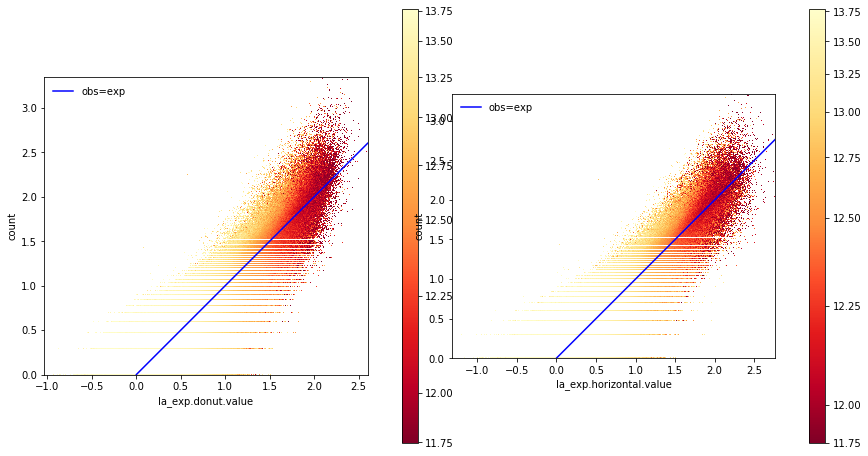

In [14]:
# def quick_obs_exp_scatter(data,
#                           axis,
#                           xlabel='la_exp.donut.value',
#                           ylabel='count'):
#     # obs exp
#     # the base scatter:
#     sct = axis.scatter(data[xlabel],
#                       data[ylabel],
#                       # color dots on the scatter by their genomic separation
#                       c=data['bin2_id']-data['bin1_id'],
#                       vmin=0,
#                       vmax = 100,
#                       cmap="YlOrRd_r")
#     # we can add a visual of the lambda-chunking grid on top of obs/exp scatter ...
#     # plt.vlines(ledges[1:-15],ymin=0.5,ymax=900,color='red')
#     axis.set_xscale('log')
#     axis.set_yscale('log')
#     # limits
#     axis.set_xlim(0.5,700)
#     axis.set_ylim(0.5,1200)
#     # labels
#     axis.set_ylabel(ylabel)
#     axis.set_xlabel(xlabel)
#     # return axes
#     return sct

def quick_obs_exp_scatter_2(data,
                          axis,
                          xlabel='la_exp.donut.value',
                          ylabel='count'):
    _data = data.copy()
    _data = _data.transform({
       xlabel: lambda _: np.log10(_),
       ylabel: lambda _: np.log10(_),
       "bin1_id": lambda _: _*1.*binsize,
       "bin2_id": lambda _: _*1.*binsize,
    }).replace([np.inf, -np.inf], np.nan).dropna(axis=0)
    
    color_key = "separation"
    _data[color_key] = np.log(_data['bin2_id'] - _data['bin1_id'])

    sct = dsshow(
           _data,
           ds.Point(xlabel, ylabel),
           ds.mean(color_key),
           norm='eq_hist',
           cmap="YlOrRd_r", #YlOrRd_r #cividis
#            aspect=1,
           ax=axis)
    #     plt.legend(handles=_da2.get_legend_elements());
    
    # draw an y=x - straight line of obs==exp :
    _from,_to = zip(*[
        axis.get_xlim(),
        axis.get_ylim()
    ])
    _xy = [max(_from), min(_to)]
    axis.plot(_xy, _xy, 'b-', label='obs=exp')
    axis.legend(loc='upper left', frameon=False)

    axis.set_ylabel(ylabel)
    axis.set_xlabel(xlabel)
    return sct

# fig = plt.figure(figsize=(16,12),constrained_layout=True)
# gsp = fig.add_gridspec(2,2)
# # fig.add_gridspec(ncols,nrows,width_ratios,height_ratios)
# ax1 = fig.add_subplot(gsp[0,0])
fig = plt.figure(figsize=(14,8))
gs = plt.GridSpec(nrows=1,
            ncols=4,
            figure=fig,
            width_ratios=[1,0.05,1,0.05])

# we might consider "downsampling" la_exp dataframe in order to make obs/exp scatter plot less busy:
data = la_exp #.sample(frac=0.1)

ax1 = plt.subplot(gs[0])
cax1 = plt.subplot(gs[1])
sct1 = quick_obs_exp_scatter_2(data,ax1)
fig.colorbar(sct1,
             cax=cax1,
             shrink=0.99,
             pad=-0.1)

ax2 = plt.subplot(gs[2])
cax2 = plt.subplot(gs[3])
sct2 = quick_obs_exp_scatter_2(data,ax2,xlabel="la_exp.horizontal.value")
fig.colorbar(sct2,
             cax=cax2,
             shrink=0.99,
             pad=-0.1)
# # cbar
# cb = plt.colorbar(sct,cax=plt.subplot(gs[1]))
# cb.ax.get_yaxis().set_major_locator(ticker.MaxNLocator(1))
# # cb.ax.set_yticklabels(['Excluded from calculation','Included in calculations'])

# # enriched = data[data[ylabel]/data[xlabel]>1]
# # ax.scatter(enriched[xlabel],
# #             enriched[ylabel],
# #             s=80,
# #             facecolors='none',
# #             edgecolors='b')

Obs vs exp scatter plot highlights the enriched pixels:
 - pixels that are above the blue line `obs=exp` are all "enriched", i.e. for all of them `obs` is more than `exp`.
 - Problem is, such a naive way of extracting enriched interactions yields too many false positives
 - should we show a heatmap of all of such "enriched" pixels - to demonstrate that it's not so good ?!
 - we need to do more rigorous statistical analysis to extract "significantly" enriched pixels instead.

# starting from here it requires more cleaning/trimming down ...

### Extracting statistically significant interactions

So how could one extract significantly enriched interactions instead of calling every marginally brighter pixel "enriched" ?

We have our *null* hypothesis: intensity of a HiC pixel is Poisson-distributed with a certain expected. In this case that would be *locally-adjusted expected*.

Thus for the dot-calling, we could estimate a *p*-value for every pixel based on its observed intensity and its expected intensity:
```python
from scipy.stats import poisson

for k in ktypes:
    la_exp["la_exp."+k+".pval"] = 1.0 - \
            poisson.cdf(la_exp["count"],
                        la_exp["la_exp."+k+".value"])
```

However going that route would be technically challenging for the further genome-wide calculations, so we can introduce the *lambda*-chunking procedure introduced in Rao et al 2014 to tackle technicall challenges and some issues associated with the wide dynamic range of the expected for the dot-calling (due to distance decay).

# should we keep in some form or go straight to Rao procedure ?!

### now let's select pixels that are "significantly" brighter than their surroundings ...

Just use *naive* p-value thresholding for simplicity and quick turn around.

And then see where such "bright" pixels end up on the obs/exp scatter plot depending on the p-value threshold

### Rao et al 2014 statistics is more nuanced

 1. Simple p-value thresholding should be replaced to more "productive" FDR, which is more tractable and better suited for the job.
 2. Another argument is that it is "unfair" to treat all of the pixels with the same statitical testing (multiple hypothesis) - the range of "expecteds" is "too wide"
 3. 2nd point is addressed by spliting the pixels in the groups by their localy adjusted expected - the so-called $\lambda$-chunking
 4. Another nuance of $\lambda$-chunking is that Rao et al are using the upper boundary of each $\lambda$-chunk as an expected for every pixel in the chunk (clearly for technical reasons) - we could see how that affects the significance by itself.

(-100, 8500)

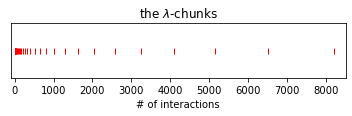

In [17]:
# The essence of lambda-chunking - let's split the surveyed pixels into "chunks" based on
# their la-expected value and do multiple hypothesis testing separately for these chunks.
nlchunks = dotfinder.HiCCUPS_W1_MAX_INDX
base = 2 ** (1/3)
ledges = np.concatenate((
    [-np.inf],
    np.logspace(0, nlchunks - 1, num=nlchunks, base=base, dtype=np.float),
    [np.inf]))

#################################################
plt.plot(ledges,np.zeros_like(ledges),'r|')
plt.title("the $\lambda$-chunks")
plt.xlabel("# of interactions")
fig = plt.gcf()
fig.set_size_inches(6,1)
ax = plt.gca()
ax.set_yticks([])
ax.set_xlim(-100,8500)

# consider embedding this picture to the markdown section ...

### after creating lambda-chunks `ledges` we use them construct histograms of interaction counts in each "bin"

### Assigning pixels to $\lambda$-chunks:

 - After defining the bins for the expected (boundaries of $\lambda$-chunks) let's actually chunk the data
 - this step involves *de novo* calculation of locally adjusted expected
 - l.a. expected is used to build histograms of observed data

In [18]:
gw_hist = dotfinder.histogram_scored_pixels(
    scored_df = la_exp,
    kernels = kernels,
    ledges = ledges,
    verbose = 1,
    obs_raw_name='count',
)

Building a histogram for kernel-type donut
Building a histogram for kernel-type vertical
Building a histogram for kernel-type horizontal
Building a histogram for kernel-type lowleft


### determine thresholds using the fdr thing ...

[we should understand a little better - what is going on here with the multiple hypothesis testing, see https://github.com/mirnylab/cooltools/issues/82]

long story short:
 - for each $\lambda$-chunk we are calculating q-values in an efficient way, skipping calculations of p-values for each surveyed pixel
 - in part this is achieved by using upper boundary of each $\lambda$-chunk as an expected for every pixel in this chunk
 - and in part the efficiency comes from collapsing identical observed values, i.e. histogramming
 - to be checked: q-values > 1.0 seem to be weird - we need to check if that is ok
 - also to be comared with the stats-packages implementations - just in case, e.g. `from statsmodels.stats import multitest; multitest.multipletests(pvals,alpha=0.99,method="fdr_bh")`


In [19]:
# this determines observed thresholds for each chunk and corresponding q-values for every observed value
fdr = 0.1
threshold_df, qvalues = dotfinder.determine_thresholds(
    kernels,
    ledges,
    gw_hist,
    fdr = fdr
)

### oveview of the 2D histogram 

x-bins corresponding to the $\lambda$-chunks and y-bins correspodning to the observed counts ...

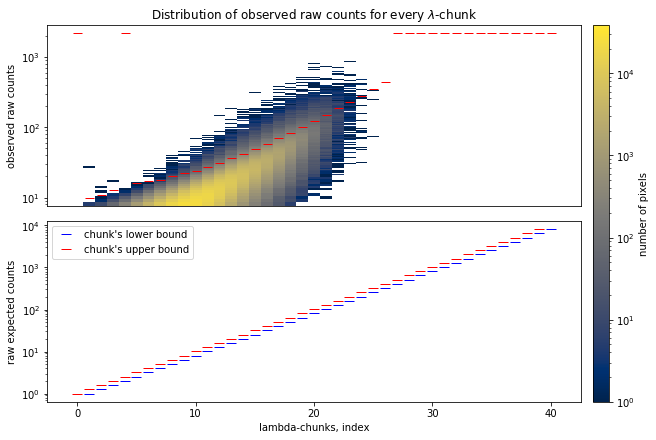

In [20]:
width, height = 9, 6
fig = plt.figure(
    figsize=(width,height),
    constrained_layout=True
)
gs = fig.add_gridspec(
    nrows=2,
    ncols=2,
    width_ratios=[10,0.3],
    height_ratios=[1,1]
)

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0],sharex=ax1)
cbar_ax = fig.add_subplot(gs[:,1])

img = ax1.imshow(
    gw_hist["donut"], # reverse cumulative hist: .iloc[::-1].cumsum(axis=0).iloc[::-1],
    aspect="auto",
    origin="lower",
    cmap="cividis",
    interpolation="nearest",
    norm = LogNorm()
)

ax1.plot(
    np.arange(threshold_df["donut"].values.size),#-0.05,
    threshold_df["donut"].values,
    color='r',
    marker="_",
    markersize=9,
    linestyle="-",
    linewidth=0,
    label=f"FDR {fdr} threshold per chunk,\nenriched pixels are above"
)

ax1.set_ylabel("observed raw counts")
# ax1.set_xlabel("lambda-chunks, index")
ax1.set_title("Distribution of observed raw counts for every $\lambda$-chunk")
ax1.set_yscale("log")
# ax1.legend()
ax1.xaxis.set_visible(False)
plt.colorbar(img,fraction=0.015,cax=cbar_ax)
cbar_ax.set_ylabel("number of pixels")


lines = ax2.plot(
    ledges[:-1], # lower chunk's bound
    "b_",
    ledges[1:], # upper chunk's bound
    "r_",
    markersize=10,
)
ax2.set_yscale("log")
ax2.set_ylabel("raw expected counts")
ax2.set_xlabel("lambda-chunks, index")
ax2.legend(
    lines,
    ["chunk's lower bound","chunk's upper bound"]
)


# beware - not every count is going to be visible on the heatmap - especially in the sparse areas

### now extract "significant" pixels using the defined thresholds_df and the same parquet file with the score dump as for the histogramming step



In [21]:
# using these caluclated thresholds of significance, we extract enriched pixels:
filtered_pixels = dotfinder.extract_scored_pixels(
            scored_df = la_exp,
            kernels = kernels,
            thresholds = threshold_df,
            ledges = ledges,
            verbose = True,
            obs_raw_name='count',
        )

In [33]:
# Included to correspond to CLI functions, might be not needed:
filtered_pixels = filtered_pixels.sort_values(['bin1_id', 'bin2_id']).reset_index(drop=True)

In [20]:
# # arbitrary p-value threshold
# p_th = 0.0001

# # let's test p-value for all of the 4 filters - feel free to play with individual filters/kernels as well:
# signif_pvals = np.ones_like(la_exp["la_exp.donut.pval"].values,dtype=np.bool)
# for k in ktypes:
#     signif_pvals = signif_pvals & (la_exp["la_exp."+k+".pval"]<=p_th)


# # plotting - consider making it shorter:
# sct = plt.scatter(la_exp[xlabel],
#                   la_exp[ylabel],
#                   # color dots on the scatter by their genomic separation
#                   c=la_exp['bin2_id']-la_exp['bin1_id'],
#                   vmin=0,
#                   vmax = 100,
#                   cmap="YlOrRd_r")

# # let's select pixels with "small" p-values:
# kinda_signif_pixels = la_exp[signif_pvals]

# plt.scatter(kinda_signif_pixels[xlabel],
#             kinda_signif_pixels[ylabel],
#             s=80,
#             facecolors='none',
#             edgecolors='b')

# # we can add a visual of the lambda-chunking grid on top of obs/exp scatter ...
# # plt.vlines(ledges[1:-15],ymin=0.5,ymax=900,color='red')

# ax = plt.gca()
# fig = plt.gcf()

# ax.set_xscale('log')
# ax.set_yscale('log')

# ax.set_xlim(0.5,700)
# ax.set_ylim(0.5,1200)

# ax.set_ylabel("count")
# ax.set_xlabel("la_exp value")

# fig.colorbar(sct)

In [21]:
# # here are trying to see the effect of using the chunk boundary as an expected instread of actual expected for a given pixel:

# # we can exaggerate the "ledges", i.e. make lambda-chunks very wide to see the side effect of replacing expected within each chunk

# for k in ktypes:
#     la_exp["la_exp."+k+".value.chunked"] = ledges[np.digitize(la_exp["la_exp."+k+".value"],ledges)]
    
# # recalculate the p-values to take 4th item into account:
# for k in ktypes:
#     la_exp["la_exp."+k+".pval"] = 1.0 - \
#             poisson.cdf(la_exp["count"],
#                         la_exp["la_exp."+k+".value.chunked"])

    
# # arbitrary p-value threshold
# p_th = 0.0001

# # let's test p-value for all of the 4 filters - feel free to play with individual filters/kernels as well:
# signif_pvals = np.ones_like(la_exp["la_exp.donut.pval"].values,dtype=np.bool)
# for k in ktypes:
#     signif_pvals = signif_pvals & (la_exp["la_exp."+k+".pval"]<=p_th)


# # plotting - consider making it shorter:
# sct = plt.scatter(la_exp[xlabel],
#                   la_exp[ylabel],
#                   # color dots on the scatter by their genomic separation
#                   c=la_exp['bin2_id']-la_exp['bin1_id'],
#                   vmin=0,
#                   vmax = 100,
#                   cmap="YlOrRd_r")

# # let's select pixels with "small" p-values:
# kinda_signif_pixels = la_exp[signif_pvals]

# plt.scatter(kinda_signif_pixels[xlabel],
#             kinda_signif_pixels[ylabel],
#             s=80,
#             facecolors='none',
#             edgecolors='b')

# # we can add a visual of the lambda-chunking grid on top of obs/exp scatter ...
# plt.vlines(ledges[1:-15],ymin=0.5,ymax=900,color='red')

# ax = plt.gca()
# fig = plt.gcf()

# ax.set_xscale('log')
# ax.set_yscale('log')

# ax.set_xlim(0.5,700)
# ax.set_ylim(0.5,1200)

# ax.set_ylabel("count")
# ax.set_xlabel("la_exp value")

# fig.colorbar(sct)

### a histogram for a particular $\lambda$-chunk

In [22]:
# binid = 7
# print(gw_hist["donut"].iloc[:,binid].values.sum())
# hs = np.clip(gw_hist["donut"].iloc[:,binid].values,a_min=None,a_max=10000)
# # hs = np.log(gw_hist["donut"].iloc[:,binid].values)
# plt.bar(gw_hist["donut"].iloc[:,binid].index,hs)
# plt.bar(threshold_df["donut"].iloc[binid],hs.max(),width=10,color='red')
# # plt.gca().set_ylim(0,1)
# # plt.gca().set_xlim(0,60)
# # gw_hist["donut"].iloc[:,20]

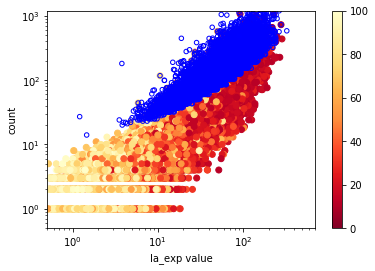

In [23]:
xlabel = 'la_exp.donut.value'
ylabel = 'count'

# we might consider "downsampling" la_exp dataframe in order to make obs/exp scatter plot less busy:
sub_la_exp = la_exp.sample(frac=0.1)

sct = plt.scatter(sub_la_exp[xlabel],
                  sub_la_exp[ylabel],
                  # color dots on the scatter by their genomic separation
                  c=sub_la_exp['bin2_id']-sub_la_exp['bin1_id'],
                  vmin=0,
                  vmax = 100,
                  cmap="YlOrRd_r")



plt.scatter(filtered_pixels[xlabel],
            filtered_pixels[ylabel],
            s=20,
            facecolors='none',
            edgecolors='b')

# we can add a visual of the lambda-chunking grid on top of obs/exp scatter ...
# plt.vlines(ledges[1:-15],ymin=0.5,ymax=900,color='red')

ax = plt.gca()
fig = plt.gcf()

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(0.5,700)
ax.set_ylim(0.5,1200)

ax.set_ylabel("count")
ax.set_xlabel("la_exp value")

fig.colorbar(sct)

### annotate filtered pixeles and cluster them -> get centroids after that to proceed with post-processing ...

In [34]:
filtered_pixels_qvals = dotfinder.annotate_pixels_with_qvalues(filtered_pixels,
                                                                qvalues,
                                                                kernels)

In [35]:
filtered_pixels_qvals

,bin1_id,bin2_id,count,la_exp.donut.value,la_exp.vertical.value,la_exp.horizontal.value,la_exp.lowleft.value,la_exp.donut.qval,la_exp.vertical.qval,la_exp.horizontal.qval,la_exp.lowleft.qval
0,24,63,200,37.483349,52.568369,39.426171,29.679185,1.361158e-68,1.183617e-39,2.955261e-68,1.584154e-84
1,24,64,96,38.125550,58.692623,32.771035,38.932091,9.896425e-12,1.902852e-03,1.212370e-11,1.097633e-11
2,24,66,96,34.313966,42.618940,46.992987,49.608431,9.896425e-12,5.559620e-07,5.215801e-07,4.539548e-07
3,25,63,83,33.370162,48.137105,37.249194,27.782103,2.164875e-07,5.810874e-04,2.444956e-07,1.146548e-11
4,25,66,71,31.090400,33.839148,38.936239,40.775457,2.825032e-07,3.803415e-04,3.636654e-04,4.686891e-02
...,...,...,...,...,...,...,...,...,...,...,...
12495,32499,32528,71,40.828036,42.112054,49.363398,33.749550,5.604345e-02,6.055405e-02,5.773952e-02,3.029508e-04
12496,32514,32527,132,84.419010,93.883501,83.137978,93.254834,1.065917e-02,1.430992e-02,1.415998e-02,1.130452e-02
12497,32516,32528,320,125.894708,129.103725,144.422006,137.172987,7.618612e-45,3.766248e-27,3.067311e-27,2.574726e-27
12498,32516,32529,228,85.802157,79.274353,110.427028,89.719801,8.579884e-26,5.358240e-39,1.470028e-14,1.021833e-25


In [36]:
filtered_pixels_annotated = cooler.annotate(filtered_pixels_qvals, clr.bins()[:])
filtered_pixels_annotated = cooltools.lib.assign_regions(filtered_pixels_annotated, hg38_arms)

In [37]:
filtered_pixels_annotated

,chrom1,start1,end1,weight1,chrom2,start2,end2,weight2,bin1_id,bin2_id,count,la_exp.donut.value,la_exp.vertical.value,la_exp.horizontal.value,la_exp.lowleft.value,la_exp.donut.qval,la_exp.vertical.qval,la_exp.horizontal.qval,la_exp.lowleft.qval,region
0,chr2,240000,250000,0.011884,chr2,630000,640000,0.010623,24,63,200,37.483349,52.568369,39.426171,29.679185,1.361158e-68,1.183617e-39,2.955261e-68,1.584154e-84,chr2_p
1,chr2,240000,250000,0.011884,chr2,640000,650000,0.009881,24,64,96,38.125550,58.692623,32.771035,38.932091,9.896425e-12,1.902852e-03,1.212370e-11,1.097633e-11,chr2_p
2,chr2,240000,250000,0.011884,chr2,660000,670000,0.010581,24,66,96,34.313966,42.618940,46.992987,49.608431,9.896425e-12,5.559620e-07,5.215801e-07,4.539548e-07,chr2_p
3,chr2,250000,260000,0.014055,chr2,630000,640000,0.010623,25,63,83,33.370162,48.137105,37.249194,27.782103,2.164875e-07,5.810874e-04,2.444956e-07,1.146548e-11,chr2_p
4,chr2,250000,260000,0.014055,chr2,660000,670000,0.010581,25,66,71,31.090400,33.839148,38.936239,40.775457,2.825032e-07,3.803415e-04,3.636654e-04,4.686891e-02,chr2_p
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12495,chr17,82790000,82800000,0.011820,chr17,83080000,83090000,0.010261,32499,32528,71,40.828036,42.112054,49.363398,33.749550,5.604345e-02,6.055405e-02,5.773952e-02,3.029508e-04,chr17_q
12496,chr17,82940000,82950000,0.012090,chr17,83070000,83080000,0.011253,32514,32527,132,84.419010,93.883501,83.137978,93.254834,1.065917e-02,1.430992e-02,1.415998e-02,1.130452e-02,chr17_q
12497,chr17,82960000,82970000,0.009431,chr17,83080000,83090000,0.010261,32516,32528,320,125.894708,129.103725,144.422006,137.172987,7.618612e-45,3.766248e-27,3.067311e-27,2.574726e-27,chr17_q
12498,chr17,82960000,82970000,0.009431,chr17,83090000,83100000,0.013658,32516,32529,228,85.802157,79.274353,110.427028,89.719801,8.579884e-26,5.358240e-39,1.470028e-14,1.021833e-25,chr17_q


In [38]:
expected_regions = expected.reset_index()["region"].unique()
expected_regions

array(['chr2_p', 'chr2_q', 'chr17_p', 'chr17_q'], dtype=object)

In [39]:
# filtered_pixels_annotated = cooler.annotate(filtered_pixels_qvals, clr.bins()[:])
centroids = dotfinder.clustering_step(
    filtered_pixels_annotated, 
    expected_regions, 
    dots_clustering_radius, 
    verbose
    )
print("Number of clustered pixels, i.e. centroids {}".format(len(centroids)))

Clustering is completed:
977 clusters detected
3.65+/-3.42 mean size

Clustering is completed:
1541 clusters detected
3.59+/-3.23 mean size

Clustering is completed:
242 clusters detected
3.44+/-3.08 mean size

Clustering is completed:
682 clusters detected
3.76+/-3.27 mean size

Clustering is over!
Number of clustered pixels, i.e. centroids 3442


In [40]:
final_out = dotfinder.thresholding_step(centroids)

In [41]:
len(final_out)

2454

## stuff that require clean up, but might be usefull in general 

/home/agalicina/anaconda3/envs/python37/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


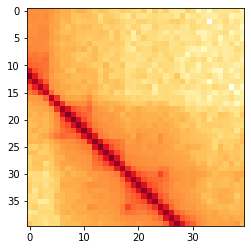

In [42]:
# plt.imshow(np.log(clr.matrix()[18030:18100,18030:18100]),cmap='YlOrRd')
# plt.scatter(53,18,s=80, facecolors='none', edgecolors='b')

bin1,bin2 = 18030+18,18030+53

bin1_n,bin2_n = 18030+23,18030+49


bin1,bin2 = 24322, 24334

plt.imshow(np.log(clr.matrix(balance=True)[bin1-20:bin1+20,bin2-20:bin2+20]),cmap='YlOrRd')

# something to have in mind - is the difference between JUicer balancing and cooler balacning ...
# MAD max filtering in particular
# in Juicer some of thesparse/low coverage regions are kept - what re the effects on the distriubtions, etc
# to be seen
# here is the region for reference: chr1:242,019,651-244,387,558 & chr1:242,713,339-243,695,154 [offset 0,0:0,0]

# dddd = cccc[(cccc['bin1_id']==bin1)&(cccc['bin2_id']==bin2)]
# eeee = cccc[(cccc['bin1_id']==bin1_n)&(cccc['bin2_id']==bin2_n)]

# (cccc['bin2_id']-cccc['bin1_id']).min()

Text(0, 0.5, 'la_exp value')

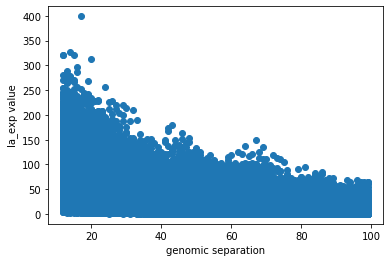

In [43]:
# also supplementary stuff to note
# about the previous point - how do we ended up having super small la_exp at small genomic separatrions ...
xlabel = 'la_exp.donut.value'
ylabel = 'count'

plt.scatter(la_exp['bin2_id']-la_exp['bin1_id'],(la_exp[xlabel]))
# plt.scatter(dddd[xlabel],dddd[ylabel], s=80, facecolors='none', edgecolors='r')
# plt.scatter(eeee[xlabel],eeee[ylabel], s=80, facecolors='none', edgecolors='y')

ax = plt.gca()

ax.set_xlabel("genomic separation")
ax.set_ylabel("la_exp value")